# Penalized Regression

When running a regression with many predictors the results have a tendency to overfit the data, reducing out-of-sample predictive properties. 

Penalized regression eases this problem by forcing the regression estimator to shrink the coefficients towards 0 in order to avoid the "penalty" term imposed on the coefficients. This process is closely related to the idea of Bayesian shrinkage, and indeed standard penalized regression results are equivalent to regression performed using [certain Bayesian priors](https://amstat.tandfonline.com/doi/abs/10.1198/016214508000000337?casa_token=DE6O93Bz7uUAAAAA:Ff_MiPXvPH32NA2hnGtZtqb8grXEiEqF0fdO3B0p_a6wOaqRciCZ4ASwxn69gdOb93Lbt-HSyK1o4As) (more about this in the next lab).

Regular OLS selects coefficients $\hat{\beta}$ to minimize the sum of squared errors:

$$
\min\sum_i(y_i - X_i\hat{\beta})^2
$$

Penalized regressions similarly select coefficients to minimize a similar objective function by adding a penalty term $\lambda\lVert\beta\rVert_p$ to that objective function, where $\lambda$ is a tuning parameter that determines how harshly to penalize coefficients, and $\lVert\beta\rVert_p$ is the $p$-norm of the coefficients, or $\sum_j\lvert\beta\rvert^p$. Thus, the objective function becomes,

$$
\min\left(\sum_i(y_i - X_i\hat{\beta})^2 + \lambda\left\lVert\beta\right\rVert_p \right).
$$

Typically $p$ is set to 1 for LASSO regression (least absolute shrinkage and selection operator), which has the effect of tending to set coefficients to 0, i.e. model selection, or to 2 for Ridge Regression. Elastic net regression provides a weighted mix of LASSO and Ridge penalties, commonly referring to the weight as $\alpha$. 

## Remarks

- To avoid being penalized for a constant term, or by differences in scale between variables, it is a very good idea to standardize each variable (subtract the mean and divide by the standard deviation) before running a penalized regression.
- Penalized regression can be run for logit and other kinds of regression, not just linear regression. Using penalties with general linear models like logit is common.
- Penalized regression coefficients are designed to improve out-of-sample prediction, but they are biased. If the goal is estimation of a parameter, rather than prediction, this should be kept in mind. A common procedure is to use LASSO to select variables, and then run regular regression models with the variables that LASSO has selected.
- The $\lambda$ parameter is often chosen using cross-validation. Many penalized regression commands include an option to select $\lambda$ by cross-validation automatically.
- LASSO models commonly include variables along with polynomial transformation of those variables and interactions, allowing LASSO to determine which transformations are worth keeping.


### Overfitting and Regularization 

You might be wondering, “Why would we ever want to throw variables out,
can’t that only hurt our model?”

The primary answer: it helps us avoid a common issue called **overfitting**.

Overfitting occurs when a model that specializes its coefficients too much on the
data it was trained on, and only to perform poorly when predicting on data
outside the training set.

The extreme example of overfitting is a model that can perfectly memorize the
training data, but can do no better than just randomly guess when predicting
on a new observation.

The techniques applied to reduce overfitting are known as **regularization**.

Regularization is an attempt to limit a model’s ability to specialize too narrowly
on training data (e.g. limit overfitting) by penalizing extreme values of the
model’s parameters.

The additional term in the lasso regression loss function ($ \alpha ||\beta||_1 $)
is a form of regularization.



### Dataset

Let’s load the dataset and take a quick look at our task.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

colors = ['#165aa7', '#cb495c', '#fec630', '#bb60d5', '#f47915', '#06ab54', '#002070', '#b27d12', '#007030']

# We will import all these here to ensure that they are loaded, but
# will usually re-import close to where they are used to make clear
# where the functions come from
from sklearn import (
    linear_model, metrics, neural_network, pipeline, model_selection
)

url = "https://datascience.quantecon.org/assets/data/kc_house_data.csv"
df = pd.read_csv(url)
#df.info()
scaler = StandardScaler()


X = df.drop(["price", "date", "id"], axis=1).copy()

# convert everything to be a float for later on
for col in list(X):
    X[col] = X[col].astype(float)
#X.head()
y = np.log(df["price"])
df["log_price"] = y
# standardize data
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#y.head()
#Note: Uncomment the previous lines to inspect the data. We've done this in previous labs with this data so I'm going to skip this step here. 


In [2]:
scaler.fit_transform(X)

array([[-0.39873715, -1.44746357, -0.97983502, ..., -0.30607896,
        -0.9433552 , -0.26071541],
       [-0.39873715,  0.1756067 ,  0.53363434, ..., -0.74634143,
        -0.43268619, -0.18786773],
       [-1.47395936, -1.44746357, -1.42625404, ..., -0.13565477,
         1.07013975, -0.17237524],
       ...,
       [-1.47395936, -1.77207762, -1.15404732, ..., -0.60432128,
        -1.41025258, -0.39414129],
       [-0.39873715,  0.50022075, -0.52252773, ...,  1.02891048,
        -0.8412214 , -0.42051149],
       [-1.47395936, -1.77207762, -1.15404732, ..., -0.60432128,
        -1.41025258, -0.41794772]])

## Lasso Regression

Lasso regression is very closely related to linear regression.

The lasso model also generates predictions using $ y = X \beta $ but
optimizes over a slightly different loss function.

The optimization problem solved by lasso regression can be written as

$$
\min_{\beta} {|| X \beta - y||_2}^2 + \underbrace{\alpha {|| \beta ||_1}}_{\text{penalty}}
$$

where $ || a ||_1 = \sum_{i=1}^N | a_i| $ is the [l1-norm](http://mathworld.wolfram.com/L1-Norm.html) and $ \alpha $ is called the regularization parameter.

The additional term penalizes large coefficients and in practice, effectively sets coefficients to zero
for features that are not informative about the
target.

Let’s see an example of what this looks like using the full feature set in
`X`.

In [3]:
lr_model = linear_model.LinearRegression()
lr_model.fit(X, y)

lasso_model = linear_model.Lasso()
lasso_model.fit(X, y)

lasso_coefs = pd.Series(dict(zip(list(X), lasso_model.coef_)))
lr_coefs = pd.Series(dict(zip(list(X), lr_model.coef_)))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linreg=lr_coefs))
coefs.round(4)

,lasso,linreg
bedrooms,0.0,-0.0114
bathrooms,0.0,0.0532
sqft_living,0.0,0.0654
sqft_lot,0.0,0.0195
floors,0.0,0.0406
waterfront,0.0,0.0321
view,0.0,0.0463
condition,0.0,0.0408
grade,0.0,0.1868
sqft_above,0.0,0.0536


Notice that many coefficients from the lasso regression have been set to
zero.

The intuition here is that the corresponding features hadn’t provided
enough predictive power to be worth considering alongside the other features.

The default value for the $ \alpha $ parameter is 1.0.

Larger $ \alpha $ values cause coefficients to shrink (and maybe
additional ones to be thrown out).

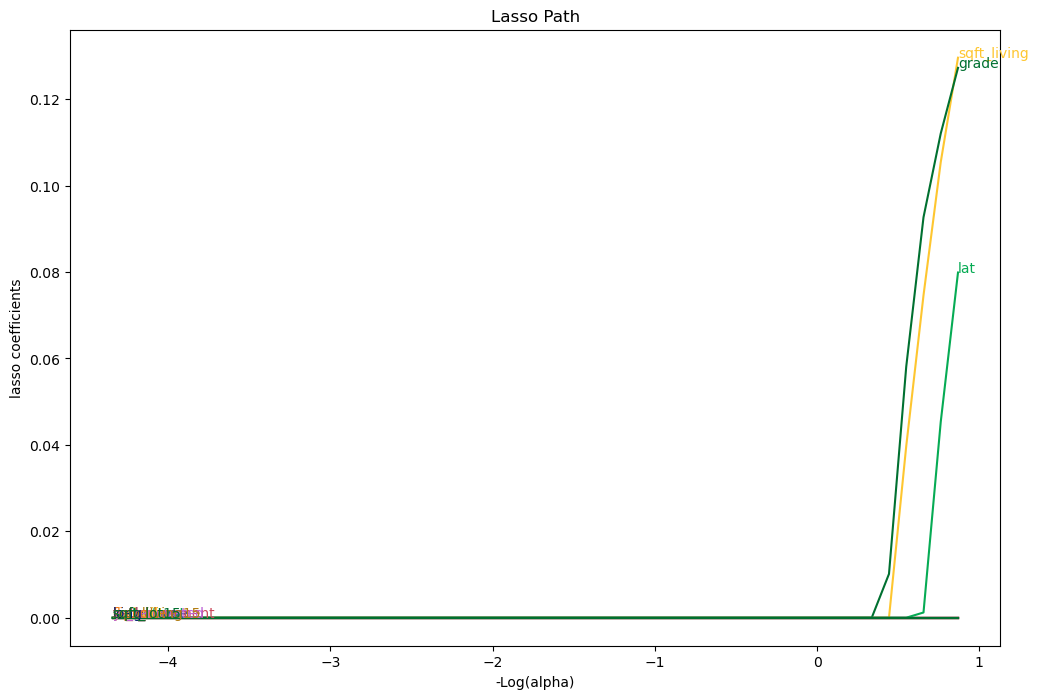

In [4]:
# Compute lasso for many alphas (the lasso path)
from itertools import cycle
alphas = np.exp(np.linspace(10, -2, 50))
alphas, coefs_lasso, _ = linear_model.lasso_path(X, y, alphas=alphas, max_iter=10000)

# plotting
fig, ax = plt.subplots(figsize=(12, 8))
color_cycle = cycle(colors)
log_alphas = -np.log10(alphas)
for coef_l, c, name in zip(coefs_lasso, color_cycle, list(X)):
   ax.plot(log_alphas, coef_l, c=c)
   ax.set_xlabel('-Log(alpha)')
   ax.set_ylabel('lasso coefficients')
   ax.set_title('Lasso Path')
   ax.axis('tight')
   maxabs = np.max(np.abs(coef_l))
   i = [idx for idx in range(len(coef_l)) if abs(coef_l[idx]) >= (0.9*maxabs)][0]
   xnote = log_alphas[i]
   ynote = coef_l[i]
   ax.annotate(name, (xnote, ynote), color=c)

Let’s demonstrate the overfitting and regularization phenomenon on our housing
price data as follows:

1. Split the data set into training and testing subsets. We will use the first 50 observations for training and the rest for testing.  
1. Fit the linear regression model and report MSE on training and testing datasets.  
1. Fit the lasso model and report the same statistics.  


In [5]:
def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )

n_test = 50
X_train = X.iloc[:n_test, :]
X_test = X.iloc[n_test:, :]
y_train = y.iloc[:n_test]
y_test = y.iloc[n_test:]

fit_and_report_mses(linear_model.LinearRegression(), X_train, X_test, y_train, y_test)

{'mse_train': 0.055456271715772824, 'mse_test': 0.6705205330638009}

In [6]:
fit_and_report_mses(linear_model.Lasso(), X_train, X_test, y_train, y_test)

{'mse_train': 0.28276356426271987, 'mse_test': 0.2774907707201781}

Notice how the MSE on the training dataset was smaller for the linear model
without the regularization, but the MSE on the test dataset was much
higher.

This strongly suggests that the linear regression model was
overfitting.

### Cross-validation of Regularization Parameter

The regularization parameter has a large impact on overfitting. Moreover, the relationship between the test data MSE and $ \alpha $ is
complicated and non-monotonic.

One popular method for choosing the regularization parameter is cross-validation.

Roughly speaking, cross-validation splits the dataset into many training/testing
subsets, then chooses the regularization parameter value that minimizes the
average MSE.

More precisely, k-fold cross-validation does the following:

1. Partition the dataset randomly into k subsets/”folds”.  
1. Compute $ MSE_j(\alpha)= $ mean squared error in j-th subset
  when using the j-th subset as test data, and other k-1 as training
  data.  
1. Minimize average (across folds) MSE $ \min_\alpha \frac{1}{k}
  \sum_{j=1}^k MSE_j(\alpha) $.  


The following code plots 5-fold, cross-validated MSE as a function of
$ \alpha $, using the same training data as above.

In [8]:
from sklearn.model_selection import cross_val_score

mse["cv"] = [-np.mean(cross_val_score(linear_model.Lasso(alpha=alpha, max_iter=50000),
                                  X_train, y_train, cv=5, scoring='neg_mean_squared_error'))
          for alpha in alphas]
mse.plot(x="log_alpha", y="cv", c=colors[2], ax=ax)
ax.annotate("5 fold cross-validation", (mse.log_alpha[40], mse.cv[40]), color=colors[2])
ax.get_legend().remove()
ax.set_xlabel(r"$-\log(\alpha)$")
ax.set_ylabel("MSE")
fig

TypeError: list indices must be integers or slices, not str

scikit learn also includes methods to automate the above and select
$ \alpha $.

In [ ]:
# LassoCV exploits special structure of lasso problem to minimize CV more efficiently
lasso = linear_model.LassoCV(cv=5).fit(X_train,y_train)
-np.log10(lasso.alpha_) # should roughly = minimizer on graph, not exactly equal due to random splitting

-1.9732104006516822

### Holdout

Practitioners often use another technique to avoid overfitting, called
*holdout*.

We demonstrated an extreme example of applying holdout above when we used only
the first 50 observations to train our models.

In general, good practice is to split the entire dataset into a training subset
and testing or validation subset.

The splitting should be done randomly. It should leave enough data in the
training dataset to produce a good model, but also enough in the validation
subset to determine the degree of overfitting.

There aren’t hard and fast rules for how much data to put in each subset, but a
reasonable default uses 75% of the data for training and the
rest for testing.

As in the example above, the training data is often further split
while selecting regularization parameters with cross-validation.

The `sklearn` function `model_selection.train_test_split` will do this for you:

In [ ]:
# note test_size=0.25 is the default value, but is shown here so you
# can see how to change it
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

### Exercise

Run the same experiment using Ridge and Elastic Net Regression as your prefered regularization choice. How does it compare to LASSO and OLS ? 

## References

- Chapter 5 of Jerome Friedman, Trevor Hastie, and Robert Tibshirani. *The elements of statistical learning*. Springer series in statistics, 2009. URL: [https://web.stanford.edu/~hastie/ElemStatLearn/](https://web.stanford.edu/~hastie/ElemStatLearn/)

- The Library of Statistical Techniques (LOST)! URL: [https://lost-stats.github.io/](https://lost-stats.github.io/)